In [1]:
import numpy as np
from sklearn import datasets
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
iris = datasets.load_iris()

# Task 1: One Vs. All SVM

$$ \frac{\partial \mathscr{L}}{\partial \mathbf{w}} = \mathbf{w} + \lambda \sum_{i} \begin{cases} 0 ,& y_i\mathbf{w}^{T}\mathbf{x}_{i} \geq 1 \\ -y_{i}\mathbf{x}_{i},& else\end{cases}$$

In [44]:
class OneVAllSVM(object):
    def __init__(self, random_seed = None):
        self.random = np.random.RandomState(random_seed)
        
        L = lambda w, x, y, lamb: .5*np.dot(w,w) + lamb * sum([max(0, 1-y[i]*np.dot(w, x[i])) for i in range(len(y))])
        self.L = L
        
        dLdw = lambda w, x, y, lamb: w + lamb * np.sum(
                [np.zeros(len(x[i])) if y[i]*np.dot(w, x[i]) >= 1 
                else -y[i]*x[i] for i in range(len(y))],
                axis = 0
            )
        self.dLdw = dLdw
        
    def train(self, x, y, lamb, lr, iters):
        n_samples = x.shape[0]
        n_features = x.shape[1]
        n_classes = len(np.unique(y))
        
        
        #Add bias column
        xw1 = np.hstack((np.ones((n_samples, 1)), x))
        
        #"Xavier" initialization
        W = self.random.normal(0, np.sqrt(2/(n_features+1)), 
                             (n_classes,n_features+1))
        self.W = W
        
        accs = []
        losses = np.zeros((iters, n_classes))
        for iteration in range(iters):
            for i in range(n_classes):
                #convert to one versus all labeling
                class_i = np.unique(y)[i]
                y_1va = np.array([1 if yi == class_i else -1 for yi in y])
                W[i,:] = W[i,:] - lr*self.dLdw(W[i,:], xw1, y_1va, lamb)
                accs.append(self.accuracy(x, y))
                losses[iteration, i] = self.L(W[i,:], xw1, y_1va, lamb)
        plt.figure()
        plt.plot(losses)
        plt.figure()
        plt.plot(accs)
    
    def predict(self, x):
        x_bias = np.hstack((np.ones((x.shape[0], 1)), x))
        return(
            np.array(
                [
                    [np.dot(self.W[i], x_bias[j]) for i in range(self.W.shape[0])]
                    for j in range(len(x_bias))
                ]
            )
        )
    def predict_labels(self, x):
        return(np.argmax(self.predict(x), 1))
    
    def accuracy(self, x, y):
        return(sum(self.predict_labels(x) == y)/float(len(y)))

In [3]:
y = iris['target']
x = iris['data']

0.69333333333333336

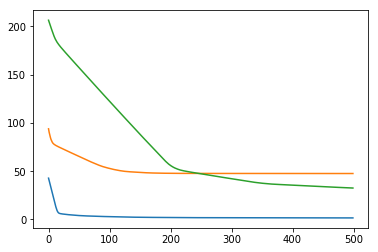

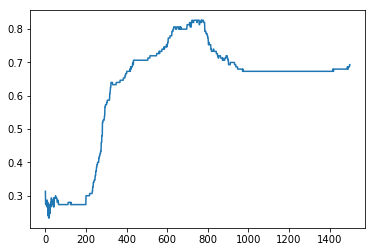

In [46]:
svm = OneVAllSVM(1234)
svm.train(x, y, lamb = .5, lr = .0001, iters = 500)
svm.accuracy(x, y)

0.93333333333333335

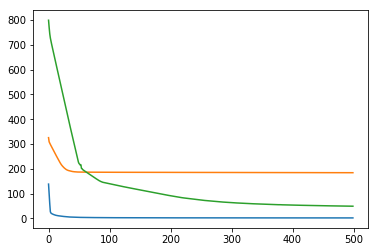

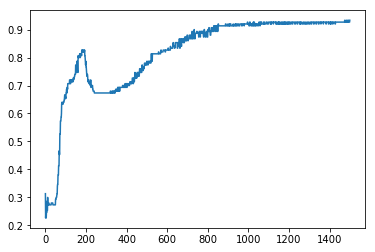

In [47]:
svm = OneVAllSVM(1234)
svm.train(x, y, lamb = 2, lr = .0001, iters = 500)
svm.accuracy(x, y)

0.95333333333333337

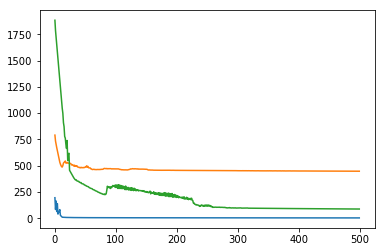

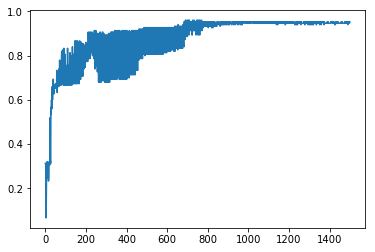

In [48]:
svm = OneVAllSVM(1234)
svm.train(x, y, lamb = 5, lr = .0001, iters = 500)
svm.accuracy(x, y)

0.95999999999999996

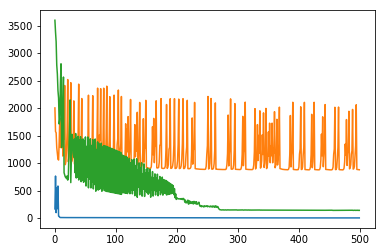

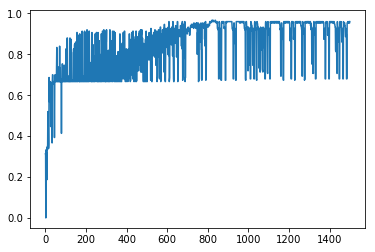

In [49]:
svm = OneVAllSVM(1234)
svm.train(x, y, lamb = 10, lr = .0001, iters = 500)
svm.accuracy(x, y)

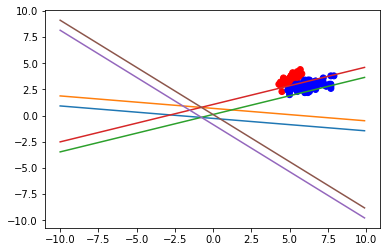

In [50]:
W = svm.W 
plotrange = np.arange(-10,10,.1)
plt.plot(plotrange, ((1-W[0,0])-W[0,1]*plotrange)/W[1,2])
plt.plot(plotrange, ((-1-W[0,0])-W[0,1]*plotrange)/W[1,2])

plt.plot(plotrange, ((1-W[1,0])-W[1,1]*plotrange)/W[1,2])
plt.plot(plotrange, ((-1-W[1,0])-W[1,1]*plotrange)/W[1,2])

plt.plot(plotrange, ((1-W[2,0])-W[2,1]*plotrange)/W[1,2])
plt.plot(plotrange, ((-1-W[2,0])-W[2,1]*plotrange)/W[1,2])

plt.scatter(x[:,0], x[:,1], color = np.array(['r' if yi ==0 else 'b' for yi in y]))

# Task 2: Explicit Multi-class SVM

$$ 
\frac{\partial \mathscr{L}}{\partial \mathbf{w}_k} =
\mathbf{w}_k + \lambda \sum_{i} \left(
\mathbf{1}_{y_i = k}\left(
\sum_{j, j \neq k} 
\begin{cases}
    0 ,& w_{k}\mathbf{x}_{i}-w_{j}\mathbf{x}_{i} \geq 1 \\
    -\mathbf{x}_{i},& else
\end{cases}
\right)+
\mathbf{1}_{y_i \neq k}\left(
\begin{cases}
    0 ,& w_{y_i}\mathbf{x}_{i}-w_{k}\mathbf{x}_{i} \geq 1 \\
    \mathbf{x}_{i},& else
\end{cases} \right)\right)
$$

In [4]:
class MCSVM(object):
    def __init__(self, random_seed = None):
        self.random = np.random.RandomState(random_seed)
        
    def L(self, W, x, y, lamb):
        return .5*sum([np.dot(W[k],W[k]) for k in range(len(W))]) + \
            lamb*sum([
                sum([
                        max(0, 1-(np.dot(W[y[i]], x[i]) - np.dot(W[k], x[i])))
                        for k in range(len(W)) if k != y[i]
                    ])
                    for i in range(len(y))
                ]
        )
        self.L = L
        
    
    def dLdw(self, W, k, x, y, lamb): 
        error_loss_sum = 0
        for i in range(len(y)):
            if k == y[i]:
                for j in range(len(W)):
                    if np.dot(W[y[i]], x[i]) - np.dot(W[j], x[i]) >= 1: 
                        error_loss_sum += np.zeros(len(x[i]))
                    elif j != k:
                        error_loss_sum += -x[i]   
            else:
                if np.dot(W[y[i]], x[i]) - np.dot(W[k], x[i]) >= 1: 
                    error_loss_sum += np.zeros(len(x[i]))
                else:
                    error_loss_sum += x[i]   
        return W[k] + lamb*error_loss_sum 
        self.dLdw = dLdw
        
    def train(self, x, y, lamb, lr, iters):
        n_samples = x.shape[0]
        n_features = x.shape[1]
        n_classes = len(np.unique(y))
        
        
        #Add bias column
        xw1 = np.hstack((np.ones((n_samples, 1)), x))
        
        #"Xavier" initialization
        W = self.random.normal(0, np.sqrt(2/(n_features+1)), 
                             (n_classes,n_features+1))
        self.W = W
        
        accs = []
        losses = np.zeros((iters))
        for iteration in range(iters):
            for i in range(n_classes):
                W[i,:] = W[i,:] - lr*self.dLdw(W, i, xw1, y, lamb)
                accs.append(self.accuracy(x, y))
                losses[iteration] = self.L(W, xw1, y, lamb)
        plt.figure()
        plt.plot(losses)
        plt.figure()
        plt.plot(accs)
    
    def predict(self, x):
        x_bias = np.hstack((np.ones((x.shape[0], 1)), x))
        return(
            np.array(
                [
                    [np.dot(self.W[i], x_bias[j]) for i in range(self.W.shape[0])]
                    for j in range(len(x_bias))
                ]
            )
        )
    def predict_labels(self, x):
        return(np.argmax(self.predict(x), 1))
    
    def accuracy(self, x, y):
        return(sum(self.predict_labels(x) == y)/float(len(y)))

0.95999999999999996

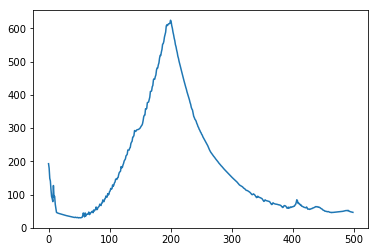

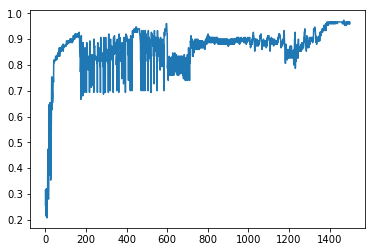

In [5]:
svm = MCSVM(1234)
svm.train(x, y, lamb = .5, lr = .001, iters = 500)
svm.accuracy(x, y)

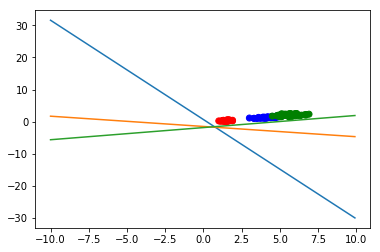

In [7]:
W = svm.W 
plotrange = np.arange(-10,10,.1)
plt.plot(plotrange, ((1-W[0,2])-W[0,3]*plotrange)/W[1,2])

plt.plot(plotrange, ((1-W[1,2])-W[1,3]*plotrange)/W[1,2])

plt.plot(plotrange, ((1-W[2,2])-W[2,3]*plotrange)/W[1,2])

plt.scatter(x[:,2], x[:,3], color = np.array(['r' if yi ==0 else 'b' if yi ==1 else 'g' for yi in y]))